In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import quantecon as qe
from numba import njit

from scipy.linalg import expm
from scipy.stats import binom

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def sim_path(T=10, seed=123, λ=0.5, α=0.7, b=10):
    """
    Generate a path for inventory starting at b, up to time T.

    Return the path as a function X(t) constructed from (J_k) and (Y_k).
    """

    J, Y = 0, b
    J_vals, Y_vals = [J], [Y]
    np.random.seed(seed)

    while True:
        W = np.random.exponential(scale=1/λ)  # W ~ Exp(λ)
        J += W
        J_vals.append(J)
        if J >= T:
            break
        # Update Y
        if Y == 0:
            Y = b
        else:
            U = np.random.geometric(α)
            Y = Y - min(Y, U)
        Y_vals.append(Y)
    
    Y_vals = np.array(Y_vals)
    J_vals = np.array(J_vals)

    def X(t):
        if t == 0.0:
            return Y_vals[0]
        else:
            k = np.searchsorted(J_vals, t)
            return Y_vals[k-1]

    return X

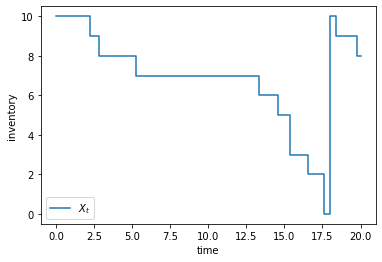

In [3]:
T = 20
X = sim_path(T=T)

grid = np.linspace(0, T, 100)

fig, ax = plt.subplots()
ax.step(grid, [X(t) for t in grid], label="$X_t$")

ax.set(xlabel="time", ylabel="inventory")

ax.legend()
plt.show()

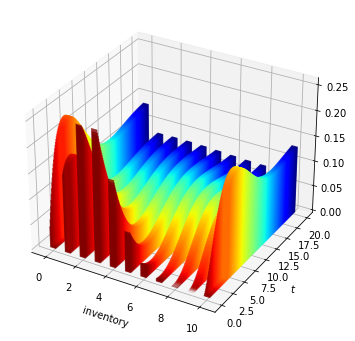

In [4]:
α = 0.6
λ = 0.5
b = 10
n = b + 1
states = np.arange(n)
I = np.identity(n)

K = np.zeros((n, n))
K[0, -1] = 1
for i in range(1, n):
    for j in range(0, i):
        if j == 0:
            K[i, j] = (1 - α)**(i-1)
        else:
            K[i, j] = α * (1 - α)**(i-j-1)


def P_t(ψ, t):
    return ψ @ expm(t * λ * (K - I))

def plot_distribution_dynamics(ax, ψ_0, steps=200, step_size=0.1):
    ψ = ψ_0
    t = 0.0
    colors = cm.jet_r(np.linspace(0.0, 1, steps))

    for i in range(steps):
        ax.bar(states, ψ, zs=t, zdir='y', 
            color=colors[i], alpha=0.8, width=0.4)
        ψ = P_t(ψ, t=step_size)
        t += step_size

    ax.set_xlabel('inventory')
    ax.set_ylabel('$t$')


ψ_0 = binom.pmf(states, n, 0.25)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
plot_distribution_dynamics(ax, ψ_0)

from myst_nb import glue
glue("flow_fig", fig, display=False)

plt.show()